In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#cr_cp = pm.df('cr_cp')
#fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#display(df_jo)

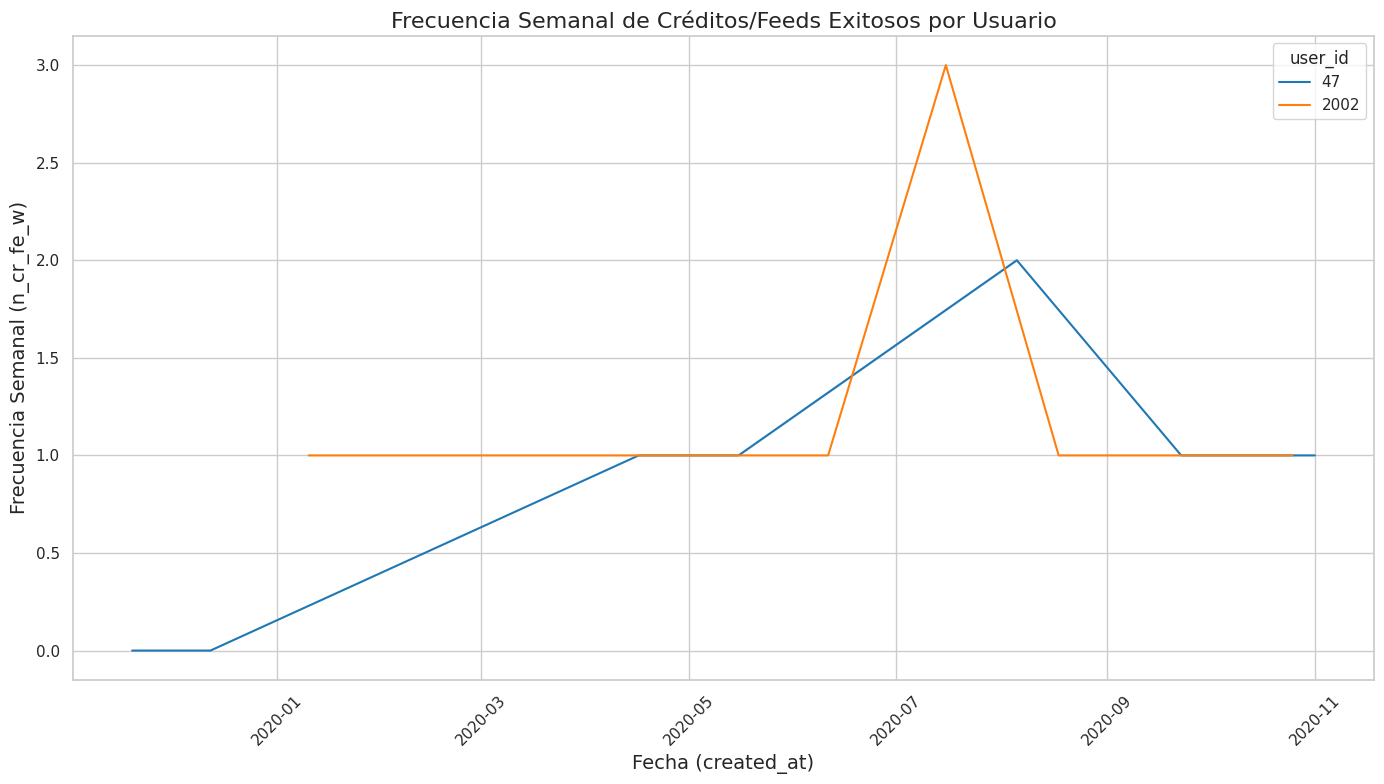

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

df_t2 = pm.df('df_jo')

# Asegurarnos de que created_at está en formato datetime
df_t2['created_at'] = pd.to_datetime(df_t2['created_at'])# .dt.to_period('D')

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear la figura
plt.figure(figsize=(14, 8))

# Filtrar un subconjunto de usuarios
usuarios_interes = [47, 2002]  # IDs de usuarios de interés
df_filtered = df_t2[df_t2['user_id'].isin(usuarios_interes)]

# Repetir el proceso con `df_filtered`
sns.lineplot(
    data=df_filtered,
    x='created_at',
    y='n_cr_fe_w',
    hue='user_id',
    palette="tab10"
)


# # Graficar la frecuencia semanal (`n_cr_fe_w`) a lo largo del tiempo por usuario
# sns.lineplot(
#     data=df_t2, 
#     x='created_at', 
#     y='n_cr_fe_w', 
#     hue='user_id',  # Cada usuario tendrá su línea de color
#     palette="tab20",  # Paleta de colores
#     legend=False,  # Opcional: ocultar la leyenda si hay muchos usuarios
#     alpha=0.7       # Hacer las líneas semitransparentes para evitar saturación
# )

# Configurar los ejes y título
plt.title('Frecuencia Semanal de Créditos/Feeds Exitosos por Usuario', fontsize=16)
plt.xlabel('Fecha (created_at)', fontsize=14)
plt.ylabel('Frecuencia Semanal (n_cr_fe_w)', fontsize=14)

# Mejorar formato de fechas en el eje X
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.tight_layout()
plt.show()


In [10]:
df = pm.df('df_jo')

good_cr = ['approved', 'money_sent', 'pending', 'direct_debit_sent', 'active', 'money_back']
good_fe = ['confirmed', 'accepted', 'cr_regular']

# Asegurarnos de que 'created_at' esté en formato datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Obtener la semana y el año como columnas separadas
df['created_at_w'] = df['created_at'].dt.isocalendar().week
df['created_at_y'] = df['created_at'].dt.isocalendar().year

# Filtrar los préstamos válidos según 'stat_cr'
df_mb = df[df['stat_cr'].isin(good_cr)]  # 'money_back', 'good_cr' puede ser una lista
df_mb = df_mb[df_mb['stat_fe'].isin(good_fe)].copy() # == 'accepted']

# Agrupar por usuario, año y semana para contar los créditos válidos
frecuencia_w = df_mb.groupby(['user_id', 'created_at_y', 'created_at_w']).size().reset_index(name='n_cr_fe_w')

# Hacer el merge con el DataFrame original, considerando año y semana
df = pd.merge(df, frecuencia_w, on=['user_id', 'created_at_y', 'created_at_w'], how='left')

# Verificar resultados para un usuario específico
dfc = df[df['user_id'] == 2002]
display(dfc[['user_id','created_at', 'created_at_w', 'created_at_y', 'id_cr', 'id_fe', 'stat_cr', 
             'stat_fe', 'n_backs', 'n_fees', 'n_recovery', 'n_cr_fe_w_x']])


,user_id,created_at,created_at_w,created_at_y,id_cr,id_fe,stat_cr,stat_fe,n_backs,n_fees,n_recovery,n_cr_fe_w_x
356,2002,2020-01-10 10:55:20.757139,2,2020,423,0,money_back,cr_regular,1,0,0,1
627,2002,2020-02-18 16:36:51.249037,8,2020,697,0,money_back,cr_regular,2,0,0,1
762,2002,2020-03-10 07:47:39.337041,11,2020,835,0,money_back,cr_regular,3,0,0,1
1098,2002,2020-04-14 21:03:09.519326,16,2020,1172,0,money_back,cr_regular,4,0,0,1
1741,2002,2020-05-15 04:09:51.091889,20,2020,1800,0,money_back,cr_regular,5,0,0,1
3171,2002,2020-06-10 23:34:13.556501,24,2020,2949,0,money_back,cr_regular,6,0,0,1
8381,2002,2020-07-15 13:17:11.174285,29,2020,8177,1674,money_back,cancelled,7,0,0,3
8382,2002,2020-07-15 13:17:11.174285,29,2020,8177,1749,money_back,accepted,7,1,0,3
8383,2002,2020-07-15 13:17:11.174285,29,2020,8177,1839,money_back,accepted,7,2,0,3
8384,2002,2020-07-15 13:17:11.174285,29,2020,8177,1977,money_back,accepted,7,3,0,3


In [17]:
# Asegurarnos de que 'created_at' esté en formato datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Obtener la semana y el año como columnas separadas
df['created_at_w'] = df['created_at'].dt.isocalendar().week
df['created_at_y'] = df['created_at'].dt.isocalendar().year

# Filtrar los préstamos válidos según 'stat_cr'
df_mb = df[df['stat_cr'].isin(good_cr)]  # 'money_back', 'good_cr' puede ser una lista

# Agrupar por usuario, año y semana para contar los créditos válidos
frecuencia_w = df_mb.groupby(['user_id', 'created_at_y', 'created_at_w']).size().reset_index(name='n_cr_fe_w')

# Hacer el merge con el DataFrame original, considerando año y semana
df = pd.merge(df, frecuencia_w, on=['user_id', 'created_at_y', 'created_at_w'], how='left')

# Verificar resultados para un usuario específico
dfc = df[df['user_id'] == 47]
display(dfc[['created_at', 'created_at_w', 'created_at_y', 'id_cr', 'id_fe', 'stat_cr', 
             'stat_fe', 'n_backs', 'n_fees', 'n_recovery', 'n_cr_fe_w']])

,created_at,created_at_w,created_at_y,id_cr,id_fe,stat_cr,stat_fe,n_backs,n_fees,n_recovery,n_cr_fe_w
0,2019-11-19 13:57:53.511561,47,2019,3,0,canceled,cr_regular,0,0,0,NaN
53,2019-12-12 14:14:14.131479,50,2019,118,0,rejected,cr_regular,0,0,0,NaN
1143,2020-04-16 08:42:15.429083,16,2020,1218,0,money_back,cr_regular,1,0,0,1.0
1771,2020-05-15 16:04:10.449840,20,2020,1832,72,money_back,cancelled,2,0,0,5.0
1772,2020-05-15 16:04:10.449840,20,2020,1832,71,money_back,cancelled,2,0,0,5.0
1773,2020-05-15 16:04:10.449840,20,2020,1832,47,money_back,cancelled,2,0,0,5.0
1774,2020-05-15 16:04:10.449840,20,2020,1832,21,money_back,cancelled,2,0,0,5.0
1775,2020-05-15 16:04:10.449840,20,2020,1832,1367,money_back,accepted,2,1,0,5.0
11530,2020-08-05 09:34:16.818322,32,2020,10942,2792,money_back,accepted,3,2,0,2.0
11531,2020-08-05 09:34:16.818322,32,2020,10942,5609,money_back,accepted,3,3,0,2.0


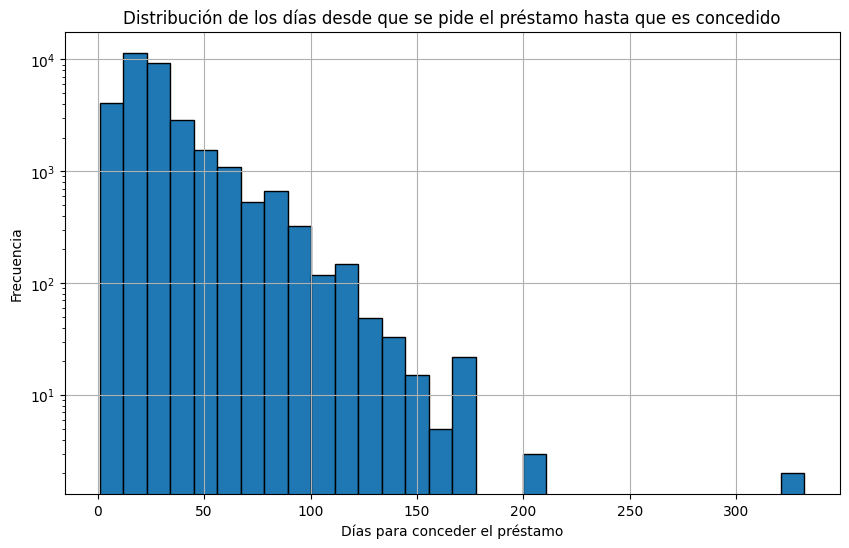

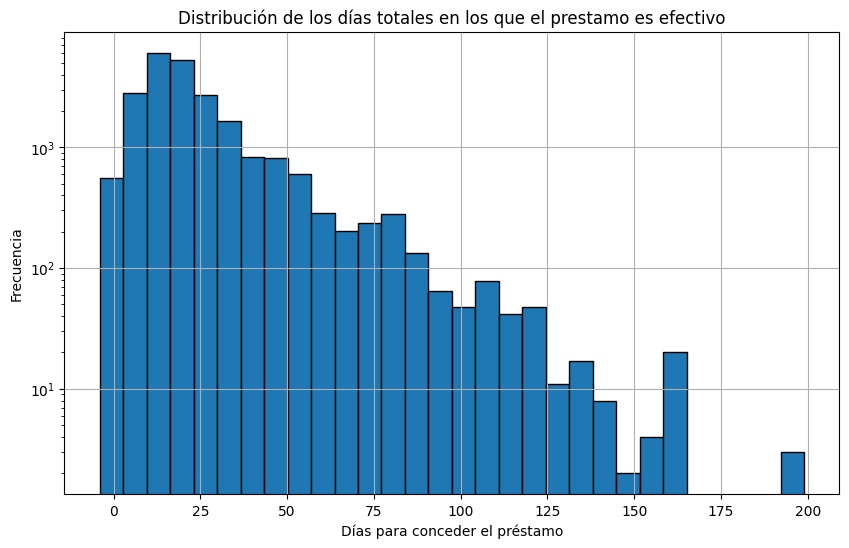

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegúrate de que las columnas de fecha estén en formato datetime
df_jo['created_at'] = pd.to_datetime(df_jo['created_at'])
df_jo['reimbursement_date'] = pd.to_datetime(df_jo['reimbursement_date'])

# Calcular los días transcurridos entre la creación y el reembolso
df_jo['days_to_concede'] = (df_jo['reimbursement_date'] - df_jo['created_at']).dt.days

# Graficar la distribución de los días
plt.figure(figsize=(10, 6))
plt.hist(df_jo['days_to_concede'], bins=30, edgecolor='black')
plt.title('Distribución de los días desde que se pide el préstamo hasta que es concedido')
plt.xlabel('Días para conceder el préstamo')
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.grid(True)
plt.show()

# Tiempo en el que la emprera realmente ha prestado el dinero
#df_jo['to_reimbur_cash'] = df_jo.reimbursement_date-df_jo.send_at
# Graficar la distribución de los días
plt.figure(figsize=(10, 6))
#plt.hist(df_jo['days_to_concede'], bins=30, edgecolor='black')
plt.hist(df_jo['to_reimbur_cash'].dt.days, bins=30, edgecolor='black')
plt.title('Distribución de los días totales en los que el prestamo es efectivo')
plt.xlabel('Días para conceder el préstamo')
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.grid(True)
plt.show()

In [35]:
good_cr = ['approved', 'money_sent', 'pending', 'direct_debit_sent', 'active', 'money_back']
good_fe = ['confirmed', 'accepted', 'cr_regular']

money_back = df['stat_cr'] == "money_back"
fee_accepted = df['stat_fe'] == "accepted"

df = pm.df('df_jo')
# Convertir las fechas a datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Filtrar los préstamos válidos según el status y fees (ajustar filtros según los datos)
#df['filtered_df'] = (df['stat_cr'] == "money_back") & (df['stat_fe'] == "accepted") & (df['fee'] > 0)
#df['days_from_last_credit'] = df.groupby('user_id')['filtered_df'].cumsum()

df['created_at_w'] = df['created_at'].dt.isocalendar().week
df_mb = df[df['stat_cr'].isin(good_cr)] # == 'money_back']
#df_mb = df_mb[df_mb['stat_fe'].isin(good_fe)].copy() # == 'accepted']
frecuencia_w = df_mb.groupby(['user_id', 'created_at_w']).size().reset_index(name='n_cr_fe_w')
df = pd.merge(df, frecuencia_w, on=['user_id', 'created_at_w'], how='left')

dfc = df[df['user_id'] == 47]
display(dfc[['created_at','created_at_w','id_cr','id_fe','stat_cr','stat_fe','n_backs','n_fees','n_recovery','created_at_w','n_cr_fe_w_x']])

# Ordenar por usuario y fecha de préstamo
#filtered_df.sort_values(by=['user_id', 'created_at'], inplace=True)

,created_at,created_at_w,id_cr,id_fe,stat_cr,stat_fe,n_backs,n_fees,n_recovery,created_at_w,n_cr_fe_w_x
0,2019-11-19 13:57:53.511561,47,3,0,canceled,cr_regular,0,0,0,47,0
53,2019-12-12 14:14:14.131479,50,118,0,rejected,cr_regular,0,0,0,50,0
1143,2020-04-16 08:42:15.429083,16,1218,0,money_back,cr_regular,1,0,0,16,1
1771,2020-05-15 16:04:10.449840,20,1832,72,money_back,cancelled,2,0,0,20,1
1772,2020-05-15 16:04:10.449840,20,1832,71,money_back,cancelled,2,0,0,20,1
1773,2020-05-15 16:04:10.449840,20,1832,47,money_back,cancelled,2,0,0,20,1
1774,2020-05-15 16:04:10.449840,20,1832,21,money_back,cancelled,2,0,0,20,1
1775,2020-05-15 16:04:10.449840,20,1832,1367,money_back,accepted,2,1,0,20,1
11530,2020-08-05 09:34:16.818322,32,10942,2792,money_back,accepted,3,2,0,32,2
11531,2020-08-05 09:34:16.818322,32,10942,5609,money_back,accepted,3,3,0,32,2


In [36]:
import pandas as pd

data = {
    'date': ['2024-09-01', '2024-09-01',
             '2024-09-12', '2024-09-22',
             '2024-09-23', '2024-10-03',
             '2024-10-13'],
    'value': ['A', 'B', 'A', 'C', 'A', 'B', 'B']
}
df = pd.DataFrame(data)
# Convert to datetime
df['date'] = pd.to_datetime(df['date'])
print(df)

# Resample by day and count
daily_counts = df.set_index('date').groupby('value').resample('ME').size().unstack(fill_value=0).unstack(fill_value=0)
print(daily_counts)

# frequency = df.groupby(['date', 'value']).size().reset_index(name='frequency')
# print(frequency)

#pivot_table = df.groupby(['date', 'value']).size().unstack(fill_value=0)
# print(pivot_table)


import pandas as pd

# Datos
data = {
    'date': ['2024-09-01', '2024-09-01',
             '2024-09-12', '2024-09-22',
             '2024-09-23', '2024-10-03',
             '2024-10-13'],
    'value': ['A', 'B', 'A', 'C', 'A', 'B', 'B']
}
df = pd.DataFrame(data)

# Convertir a datetime
df['date'] = pd.to_datetime(df['date'])

# Agrupar y contar frecuencias mensuales para cada valor en 'value'
monthly_counts = (
    df.groupby(['value', pd.Grouper(key='date', freq='ME')])  # Agrupar por 'value' y mes
      .size()  # Contar la frecuencia
      .unstack(fill_value=0)  # Transformar la columna de fechas en columnas
)

# Mostrar el resultado
print(monthly_counts)


import pandas as pd

# Datos
data = {
    'date': ['2024-09-01', '2024-09-01',
             '2024-09-12', '2024-09-22',
             '2024-09-23', '2024-10-03',
             '2024-10-13'],
    'value': ['A', 'B', 'A', 'C', 'A', 'B', 'B']
}
df = pd.DataFrame(data)

# Convertir a datetime
df['date'] = pd.to_datetime(df['date'])

# Contar las frecuencias diarias por valor
daily_counts = df.groupby(['date', 'value']).size().unstack(fill_value=0)

# Reindexar por todas las fechas originales del DataFrame
all_dates = df['date'].drop_duplicates().sort_values()
daily_counts = daily_counts.reindex(all_dates).fillna(0).astype(int)

# Mostrar el resultado
print(daily_counts)


import pandas as pd

# Datos
data = {
    'date': ['2024-09-01', '2024-09-01',
             '2024-09-12', '2024-09-22',
             '2024-09-23', '2024-10-03',
             '2024-10-13'],
    'value': ['A', 'B', 'A', 'C', 'A', 'B', 'B']
}
df = pd.DataFrame(data)

# Convertir a datetime
df['date'] = pd.to_datetime(df['date'])

# Agregar columna para el mes correspondiente
df['month'] = df['date'].dt.to_period('M')

# Calcular las frecuencias mensuales
monthly_counts = (
    df.groupby(['month', 'value'])  # Agrupar por mes y valor
      .size()                       # Contar frecuencias
      .unstack(fill_value=0)        # Transformar los valores en columnas
)

# Volver a incorporar las fechas originales con sus valores mensuales
df_with_monthly_counts = df[['date', 'month']].drop_duplicates().merge(
    monthly_counts.reset_index(),
    on='month',
    how='left'
)

# Mostrar el resultado
print(df_with_monthly_counts)


        date value
0 2024-09-01     A
1 2024-09-01     B
2 2024-09-12     A
3 2024-09-22     C
4 2024-09-23     A
5 2024-10-03     B
6 2024-10-13     B
date        value
2024-09-30  A        3
            B        1
            C        1
2024-10-31  A        0
            B        2
            C        0
dtype: int64
date   2024-09-30  2024-10-31
value                        
A               3           0
B               1           2
C               1           0
value       A  B  C
date               
2024-09-01  1  1  0
2024-09-12  1  0  0
2024-09-22  0  0  1
2024-09-23  1  0  0
2024-10-03  0  1  0
2024-10-13  0  1  0
        date    month  A  B  C
0 2024-09-01  2024-09  3  1  1
1 2024-09-12  2024-09  3  1  1
2 2024-09-22  2024-09  3  1  1
3 2024-09-23  2024-09  3  1  1
4 2024-10-03  2024-10  0  2  0
5 2024-10-13  2024-10  0  2  0


In [ ]:
import pandas as pd

# Datos
data = {
    'date': ['2024-09-01', '2024-09-01',
             '2024-09-12', '2024-09-22',
             '2024-09-23', '2024-10-03',
             '2024-10-13'],
    'value': ['A', 'B', 'A', 'C', 'A', 'B', 'B']
}
df = pd.DataFrame(data)

# Convertir a datetime
df['date'] = pd.to_datetime(df['date'])

# Agregar columna para el mes correspondiente
df['month'] = df['date'].dt.to_period('M')

# Calcular las frecuencias mensuales
monthly_counts = (
    df.groupby(['month', 'value'])  # Agrupar por mes y valor
      .size()                       # Contar frecuencias
      .unstack(fill_value=0)        # Transformar los valores en columnas
)

# Volver a incorporar las fechas originales con sus valores mensuales
df_with_monthly_counts = df[['date', 'month']].drop_duplicates().merge(
    monthly_counts.reset_index(),
    on='month',
    how='left'
)

# Mostrar el resultado
print(df_with_monthly_counts)


        date    month  A  B  C
0 2024-09-01  2024-09  3  1  1
1 2024-09-12  2024-09  3  1  1
2 2024-09-22  2024-09  3  1  1
3 2024-09-23  2024-09  3  1  1
4 2024-10-03  2024-10  0  2  0
5 2024-10-13  2024-10  0  2  0


In [ ]:
import pandas as pd

# Datos
data = {
    'date': ['2024-09-01', '2024-09-01',
             '2024-09-12', '2024-09-22',
             '2024-09-23', '2024-10-03',
             '2024-11-13'],
    'value': ['A', 'B', 'A', 'C', 'A', 'B', 'A']
}
df = pd.DataFrame(data)

# Convertir a datetime
df['date'] = pd.to_datetime(df['date'])

# Agregar columna para el mes correspondiente
df['month'] = df['date'].dt.to_period('M')
display(df)

# Calcular las frecuencias mensuales
monthly_counts = (
    df.groupby(['month', 'value'])
      .size()
      .reset_index(name='count')  # Convertir a DataFrame
)

# Combinar frecuencias mensuales con las fechas originales
df_with_monthly_counts = df[['date', 'month']].drop_duplicates().merge(
    monthly_counts,
    on='month',
    how='left'
)

# Ordenar el resultado
df_with_monthly_counts = df_with_monthly_counts.sort_values(['date', 'value'])

# Mostrar el resultado
print(df_with_monthly_counts)


,date,value,month
0,2024-09-01,A,2024-09
1,2024-09-01,B,2024-09
2,2024-09-12,A,2024-09
3,2024-09-22,C,2024-09
4,2024-09-23,A,2024-09
5,2024-10-03,B,2024-10
6,2024-11-13,A,2024-11


         date    month value  count
0  2024-09-01  2024-09     A      3
1  2024-09-01  2024-09     B      1
2  2024-09-01  2024-09     C      1
3  2024-09-12  2024-09     A      3
4  2024-09-12  2024-09     B      1
5  2024-09-12  2024-09     C      1
6  2024-09-22  2024-09     A      3
7  2024-09-22  2024-09     B      1
8  2024-09-22  2024-09     C      1
9  2024-09-23  2024-09     A      3
10 2024-09-23  2024-09     B      1
11 2024-09-23  2024-09     C      1
12 2024-10-03  2024-10     B      1
13 2024-11-13  2024-11     A      1


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#cr_cp = pm.df('cr_cp')
#fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()

np.random.seed(42)

#df_jo = df_jo.copy()
# Convertir columnas datetime a timestamps
# for col in df_jo.select_dtypes(include=['datetime64']).columns:
#     df_jo[col] = df_jo[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

# for col in df_jo.select_dtypes(include=['timedelta64']).columns:
#     df_jo[col] = df_jo[col].apply(lambda x: x / pd.to_timedelta(1, unit='d') if pd.notnull(x) else None)

df_jo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 56 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   id_fe                       32092 non-null  int64          
 2   fe_cr_id                    21055 non-null  float64        
 3   user_id                     32092 non-null  int64          
 4   active                      32092 non-null  int64          
 5   created_at                  32092 non-null  datetime64[ns] 
 6   created_at_fe               21055 non-null  datetime64[ns] 
 7   amount                      32092 non-null  float64        
 8   fee                         32092 non-null  float64        
 9   stat_cr                     32092 non-null  object         
 10  stat_fe                     32092 non-null  object         
 11  transfer_type               32092 non-nul

In [14]:
# Asegurarnos de que 'created_at' esté en formato datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Obtener la semana y el año como columnas separadas
df['created_at_w'] = df['created_at'].dt.isocalendar().week
df['created_at_y'] = df['created_at'].dt.isocalendar().year

# Filtrar los préstamos válidos según 'stat_cr'
df_mb = df[df['stat_cr'].isin(good_cr)]  # 'money_back', 'good_cr' puede ser una lista

# Agrupar por usuario, año y semana para contar los créditos válidos
frecuencia_w = df_mb.groupby(['user_id', 'created_at_y', 'created_at_w']).size().reset_index(name='n_cr_fe_w')

# Hacer el merge con el DataFrame original, considerando año y semana
df = pd.merge(df, frecuencia_w, on=['user_id', 'created_at_y', 'created_at_w'], how='left')

# Verificar resultados para un usuario específico
dfc = df[df['user_id'] == 47]
display(dfc[['created_at', 'created_at_w', 'created_at_y', 'id_cr', 'id_fe', 'stat_cr', 
             'stat_fe', 'n_backs', 'n_fees', 'n_recovery', 'n_cr_fe_w']])


,created_at,created_at_w,created_at_y,id_cr,id_fe,stat_cr,stat_fe,n_backs,n_fees,n_recovery,n_cr_fe_w
0,2019-11-19 13:57:53.511561,47,2019,3,0,canceled,cr_regular,0,0,0,NaN
53,2019-12-12 14:14:14.131479,50,2019,118,0,rejected,cr_regular,0,0,0,NaN
1143,2020-04-16 08:42:15.429083,16,2020,1218,0,money_back,cr_regular,1,0,0,1.0
1771,2020-05-15 16:04:10.449840,20,2020,1832,72,money_back,cancelled,2,0,0,5.0
1772,2020-05-15 16:04:10.449840,20,2020,1832,71,money_back,cancelled,2,0,0,5.0
1773,2020-05-15 16:04:10.449840,20,2020,1832,47,money_back,cancelled,2,0,0,5.0
1774,2020-05-15 16:04:10.449840,20,2020,1832,21,money_back,cancelled,2,0,0,5.0
1775,2020-05-15 16:04:10.449840,20,2020,1832,1367,money_back,accepted,2,1,0,5.0
11530,2020-08-05 09:34:16.818322,32,2020,10942,2792,money_back,accepted,3,2,0,2.0
11531,2020-08-05 09:34:16.818322,32,2020,10942,5609,money_back,accepted,3,3,0,2.0


In [15]:
df_jo = pm.df('df_jo')

# Asegurarte de que las fechas están en formato datetime
df_jo['created_at'] = pd.to_datetime(df_jo['created_at'])

# Ordenar el dataframe por usuario (si existe) y fecha de préstamo
df_jo.sort_values(by=['user_id', 'created_at'], inplace=True)

# Calcular la diferencia en días desde el último préstamo por usuario
df_jo['days_since_last_loan'] = df_jo.groupby('user_id','id_cr')['created_at'].diff().dt.days

# Llenar con un valor apropiado para los primeros préstamos, como 0 o NaN
df_jo['days_since_last_loan'].fillna(0, inplace=True)

# Revisar los resultados
print(df_jo[['user_id', 'created_at', 'days_since_last_loan']].head())



ValueError: No axis named id_cr for object type DataFrame

In [16]:
df = pm.df('df_jo')
# Clasificacion basica de los usuarios: segun los status de CR y FEEDS
good_cr = ['approved', 'money_sent', 'pending', 'direct_debit_sent', 'active', 'money_back']
good_fe = ['confirmed', 'accepted', 'cr_regular']

df['created_at'] = pd.to_datetime(df['created_at'])
df['created_at_w'] = df['created_at'].dt.isocalendar().week
df_mb = df[df['stat_cr'].isin(good_cr)] # == 'money_back']
df_mb = df_mb[df_mb['stat_fe'].isin(good_fe)] # == 'accepted']
frecuencia_w = df_mb.groupby(['user_id', 'created_at_w']).size().reset_index(name='n_cr_fe_w')
df = pd.merge(df, frecuencia_w, on=['user_id', 'created_at_w'], how='left')

dfc = df[df['user_id'] == 47]
display(dfc[['created_at','created_at_w','id_cr','id_fe','stat_cr','stat_fe','n_backs','n_fees','n_recovery','created_at_w','n_cr_fe_w']])

KeyError: "['n_cr_fe_w'] not in index"

In [8]:
# df_employ = pm.df('employ')
# # df_jo['created_at_d'] = df_jo['created_at_d'].dt.date
# df_employ['Date'] = pd.to_datetime(df_employ['Date'], format='%m-%Y')
# df_employ = df_employ.set_index('Date').resample('D').ffill().reset_index()
# display(df_employ)



# df_jo['created_at_d'] = pd.to_datetime(df_jo['created_at'])
# df_jo['created_at_d'] = df_jo['created_at_d'].dt.date


# df_employ["Date"] = pd.to_datetime(df_employ["Title"], format="%Y %b", errors="coerce").dt.date
# df_employ = df_employ[df_employ["Date"].notna()]
# df_employ = df_employ.drop(columns=['Title'])
# df_employ = df_employ.rename(columns={'Unemployment rate (aged 16 and over, seasonally adjusted): %': 'unemploy_rate'})
# df_employ = df_employ.drop_duplicates('Date')

# # Unir ambos DataFrames por la columna de fecha
# df_jo = pd.merge(df_jo, df_employ, left_on='created_at_d', right_on='Date', how='left')
# display(df_jo)

# # df_employ = pm.df('employ')
# # df_employ["fecha"] = pd.to_datetime(df_employ["Title"], format="%Y %b", errors="coerce")
# # df_employ = df_employ[df_employ["fecha"].notna()]
# # df_employ = df_employ.drop(columns=['Title'])
# # df_employ = df_employ.rename(columns={'Unemployment rate (aged 16 and over, seasonally adjusted): %': 'rate'})
# # display(df_employ)
# # df_employ.info()

